In [1]:
### CREATE VIRTUAL DISPLAY ###
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'    # tell X clients to use our virtual DISPLAY :1.0.

%matplotlib inline

### INSTALL GHOSTSCRIPT (Required to display NLTK trees) ###
!apt-get update
!apt install ghostscript python3-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 784 kB in 1s (630 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.c

# Parsing with NLTK. Probabilistic context-free grammars
Taken from the NLTK book

NLTK: several treebanks available:
* English: nltk_data/corpora/treebank/combined

* Probabilistic context-free grammars (PCFG)
* How to obtain a PCFG

## Example grammar:

In [2]:
import nltk

grammar = nltk.CFG.fromstring("""
 S -> NP V NP
 NP -> NP Sbar
 Sbar -> NP V
 NP -> 'fish'
 V -> 'fish'
 """)

sent1 = "fish fish fish fish fish".split()
sent2 = "fish fish fish fish fish fish fish".split()

chart_parser = nltk.ChartParser(grammar)

### The problem of ambiguity in NLP

In [3]:
for p in chart_parser.parse(sent1): print(p)

(S (NP fish) (V fish) (NP (NP fish) (Sbar (NP fish) (V fish))))
(S (NP (NP fish) (Sbar (NP fish) (V fish))) (V fish) (NP fish))


(S
  (NP (NP fish) (Sbar (NP fish) (V fish)))
  (V fish)
  (NP (NP fish) (Sbar (NP fish) (V fish))))


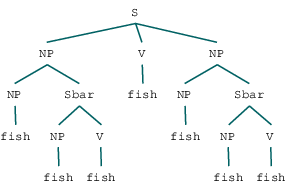

(S
  (NP fish)
  (V fish)
  (NP
    (NP (NP fish) (Sbar (NP fish) (V fish)))
    (Sbar (NP fish) (V fish))))


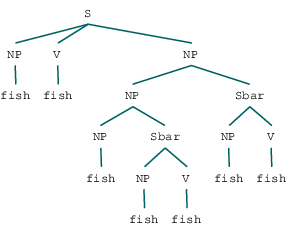

(S
  (NP fish)
  (V fish)
  (NP
    (NP fish)
    (Sbar (NP (NP fish) (Sbar (NP fish) (V fish))) (V fish))))


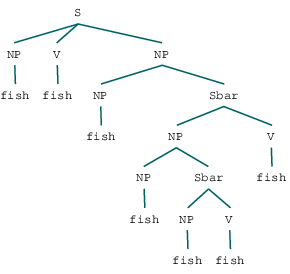

(S
  (NP
    (NP (NP fish) (Sbar (NP fish) (V fish)))
    (Sbar (NP fish) (V fish)))
  (V fish)
  (NP fish))


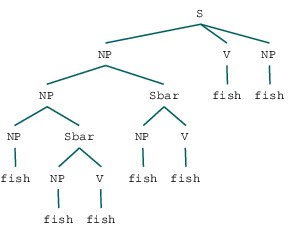

(S
  (NP
    (NP fish)
    (Sbar (NP (NP fish) (Sbar (NP fish) (V fish))) (V fish)))
  (V fish)
  (NP fish))


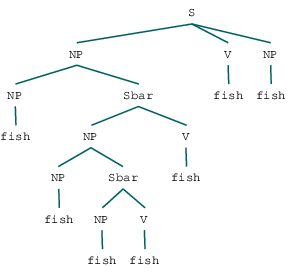

In [4]:
for p in chart_parser.parse(sent2): 
  print(p)
  display(p)

In [5]:
# How many trees?
sent3 = "fish fish fish fish fish fish fish fish fish fish fish".split()
count = 0
for p in chart_parser.parse(sent3): 
  count = count + 1
print("Number of parses: ", count)

Number of parses:  42


### Examples:
* _I saw the man with the telescope_
  * I used a telescope?
  * The man had a telescope?

* _I saw the man on the hill with the telescope_
  * How many trees?

In [6]:
grammar2 = nltk.CFG.fromstring("""
 S -> NP VP
 NP -> PRON | DT NN | NP PP
 VP -> V NP | V NP PP
 DT -> 'the'
 NN -> 'man' | 'hill' |'telescope' |'knife'
 PP -> P NP
 V -> 'saw'
 PRON -> 'I'
 P -> 'on' | 'with'
""")
chart_parser = nltk.ChartParser(grammar2)

sent1 = "I saw the man with the telescope".split()

for p in chart_parser.parse(sent1): print(p)

(S
  (NP (PRON I))
  (VP
    (V saw)
    (NP (DT the) (NN man))
    (PP (P with) (NP (DT the) (NN telescope)))))
(S
  (NP (PRON I))
  (VP
    (V saw)
    (NP
      (NP (DT the) (NN man))
      (PP (P with) (NP (DT the) (NN telescope))))))


(S
  (NP (PRON I))
  (VP
    (V saw)
    (NP (NP (DT the) (NN man)) (PP (P on) (NP (DT the) (NN hill))))
    (PP (P with) (NP (DT the) (NN knife)))))


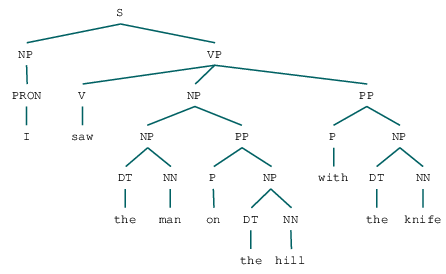

(S
  (NP (PRON I))
  (VP
    (V saw)
    (NP (DT the) (NN man))
    (PP
      (P on)
      (NP
        (NP (DT the) (NN hill))
        (PP (P with) (NP (DT the) (NN knife)))))))


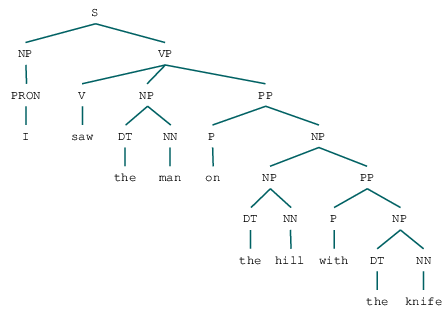

(S
  (NP (PRON I))
  (VP
    (V saw)
    (NP
      (NP (NP (DT the) (NN man)) (PP (P on) (NP (DT the) (NN hill))))
      (PP (P with) (NP (DT the) (NN knife))))))


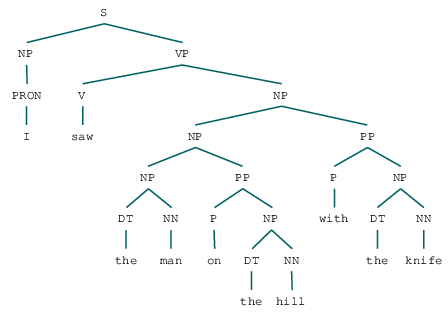

(S
  (NP (PRON I))
  (VP
    (V saw)
    (NP
      (NP (DT the) (NN man))
      (PP
        (P on)
        (NP
          (NP (DT the) (NN hill))
          (PP (P with) (NP (DT the) (NN knife))))))))


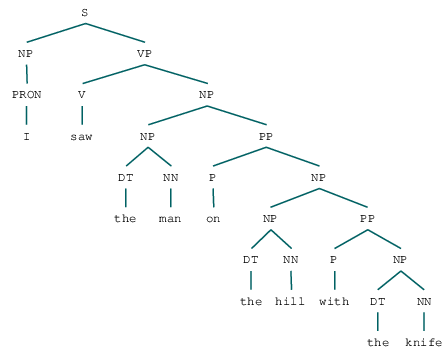

In [7]:
sent2 = "I saw the man on the hill with the knife".split()

for p in chart_parser.parse(sent2): 
  print(p)
  display(p)

## Solution: use a PCFG!

In [8]:
grammar = nltk.PCFG.fromstring("""
   S -> NP VP [1.0]
   VP -> V NP [0.5]
   VP -> V NP PP [0.5]
   V -> 'saw' [1.0]
   DT -> 'the' [1.0]
   NP -> PRON  [0.22]
   NP -> DT NN [0.56]
   NP -> NP PP [0.22]
   NN -> 'knife' [0.2]
   NN -> 'telescope' [0.2]
   NN -> 'man' [0.4]
   NN -> 'hill' [0.2]
   PP -> P NP [1.0]
   PRON -> 'I' [1.0]
   P -> 'on' [0.33]
   P -> 'with' [0.67]
""")
inside_parser = nltk.parse.InsideChartParser(grammar)
viterbi_parser = nltk.ViterbiParser(grammar)

Now we can have the different alternatives ordered by their probability:

(S
  (NP (PRON I))
  (VP
    (V saw)
    (NP (DT the) (NN man))
    (PP (P with) (NP (DT the) (NN telescope))))) (p=0.00184899)


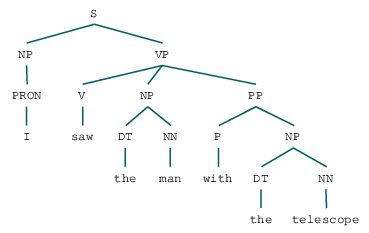

(S
  (NP (PRON I))
  (VP
    (V saw)
    (NP
      (NP (DT the) (NN man))
      (PP (P with) (NP (DT the) (NN telescope)))))) (p=0.000406777)


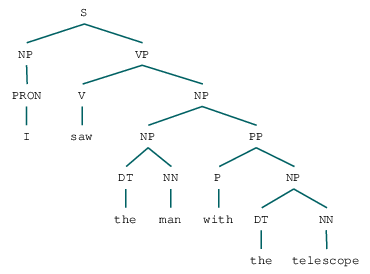

In [9]:
sent1 = "I saw the man with the telescope".split()

trees1 = inside_parser.parse(sent1)

for tree in trees1: 
  print(tree)
  display(tree)

(S
  (NP (PRON I))
  (VP
    (V saw)
    (NP (DT the) (NN man))
    (PP
      (P on)
      (NP
        (NP (DT the) (NN hill))
        (PP (P with) (NP (DT the) (NN knife))))))) (p=1.50345e-05)


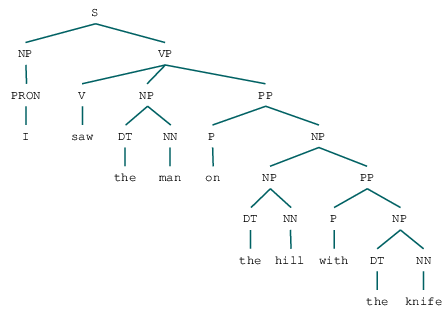

(S
  (NP (PRON I))
  (VP
    (V saw)
    (NP
      (NP (DT the) (NN man))
      (PP (P on) (NP (DT the) (NN hill))))
    (PP (P with) (NP (DT the) (NN knife))))) (p=1.50345e-05)


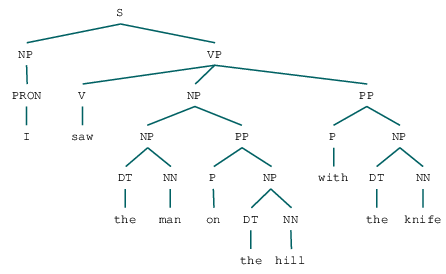

(S
  (NP (PRON I))
  (VP
    (V saw)
    (NP
      (NP (DT the) (NN man))
      (PP
        (P on)
        (NP
          (NP (DT the) (NN hill))
          (PP (P with) (NP (DT the) (NN knife)))))))) (p=3.30758e-06)


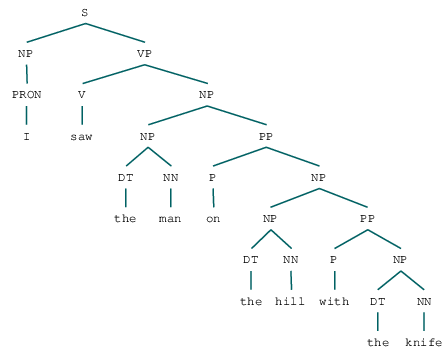

(S
  (NP (PRON I))
  (VP
    (V saw)
    (NP
      (NP
        (NP (DT the) (NN man))
        (PP (P on) (NP (DT the) (NN hill))))
      (PP (P with) (NP (DT the) (NN knife)))))) (p=3.30758e-06)


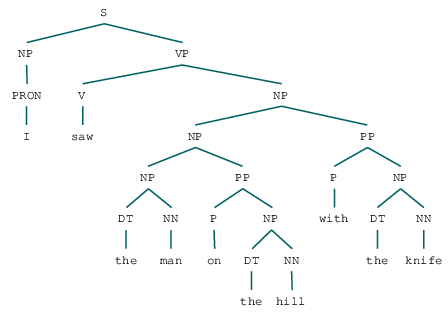

In [10]:
sent2 = "I saw the man on the hill with the knife".split()

trees2 = inside_parser.parse(sent2)

for tree in trees2: 
  print(tree)
  display(tree)

## Annotating a treebank
### We must select a set of sentences to be annotated, for example:
 * _I saw the man with the telescope_
 * _I saw the man on the hill with the telescope_


### Then the trees must be annotated (manually or semiautomatically)

**I saw the man with the telescope** <br>
(S  (NP (PRON I)) <br>
     (VP <br>
       (V saw)  <br>
       (NP (DT the) (NN man)) <br>
       (PP (P with) (NP (DT the) (NN telescope))))) <br> <br>
**I saw the man on the hill with the telescope** <br>
(S <br>
  (NP (PRON I)) <br>
  (VP <br>
    (V saw) <br>
    (NP <br>
      (NP <br>
        (NP (DT the) (NN man)) <br>
        (PP (P on) (NP (DT the) (NN hill)))) <br>
      (PP (P with) (NP (DT the) (NN telescope)))))) <br>

### How to obtain a PCFG? Counting rules <br>
S -> NP VP      [2/2] <br>
 <br>
NP -> PRON    [2/9] <br>
NP -> DT NN   [5/9] <br>
NP -> NP PP    [2/9] <br>
 <br>
VP -> V NP      [1/2] <br>
VP -> V NP PP [1/2] <br>
PP -> P NP      [2/2] <br>
 <br>
DT -> 'the'           [5/5] <br>
 <br>
NN -> 'man'          [2/5] <br>
NN -> 'hill'            [1/5] <br>
NN -> 'telescope' [2/5] <br>
 <br>
Pron -> 'I'             [2/2] <br>
 <br>
P -> 'with'            [2/3] <br>
P -> 'on'               [1/3] <br>
 <br>
V -> 'saw'             [2/2] <br>


### We have a PCFG:

S -> NP VP [1.0] <br>
VP -> V NP [0.5] <br>
VP -> V NP PP [0.5] <br>
V -> 'saw' [1.0] <br>
DT -> 'the' [1.0] <br>
NP -> PRON  [0.22] <br>
NP -> DT NN [0.56] <br>
NP -> NP PP [0.22] <br>
NN -> 'telescope' [0.4] <br>
NN -> 'man' [0.4] <br>
NN -> 'hill' [0.2] <br>
PP -> P NP [1.0] <br>
PRON -> 'I' [1.0] <br>
P -> 'on' [0.33] <br>
P -> 'with' [0.67] <br>

## Exercise: given a (small) treebank, induce a PCFG
( N ( A long) ( N ( A red) ( N hair) ) )

( N ( A nice) ( N tie) )

( N ( A ( A dark) ( A red) ) ( N hair) )

### Obtain its corresponding PCFG:

In [14]:
grammar = nltk.PCFG.fromstring("""
   N -> A N [0.57]
   N -> 'hair' [0.29]
   N -> 'tie' [0.14]
   A -> A A [0.17]
   A -> 'long' [0.17]
   A -> 'red' [0.33]
   A -> 'nice' [0.16]
   A -> 'dark' [0.16]
""")
inside_parser = nltk.parse.InsideChartParser(grammar)

### Calculate the best tree for the sentence *nice red hair*:

(N (A nice) (N (A red) (N hair))) (p=0.00497487)


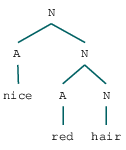

(N (A (A nice) (A red)) (N hair)) (p=0.00148373)


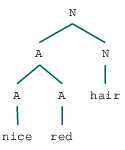

In [15]:
sentence = 'nice red hair'.split()

trees = inside_parser.parse(sentence)

for tree in trees: 
  print(tree)
  display(tree)

### Automatically calculating a PCFG given a set of bracketed trees:

In [ ]:
trees = "(N ( A long) ( N ( A red) ( N hair) ) )\n( N ( A nice) ( N tie) )\n( N ( A ( A dark) ( A red) ) ( N hair) )\n"

# Given a list of bracketed trees, get a list of all the productions
def calculate_productions(bracketed_trees):
  prods = []
  for line in trees.splitlines():
    tree = Tree.fromstring(line)
    prods += tree.productions() # add the productions of this tree
  return prods


productions = calculate_productions(trees)
print('PRODUCTIONS: ', productions)

N = nltk.Nonterminal('N')
grammar = nltk.induce_pcfg(N, productions) # Obtain a PCFG
print(grammar)

inside_parser = nltk.parse.InsideChartParser(grammar, trace=2) # Obtain syntactic analyzer (parser)

In [ ]:
sentence = 'nice red hair'.split()
trees = inside_parser.parse(sentence)

for tree in trees: 
  print(tree)
  display(tree)

## Creating a real PCFG (English)

In [ ]:
from itertools import islice
nltk.download('treebank')

productions = []
S = nltk.Nonterminal('S')

# Print some annotated sentences from the Penn treebank
for tree in nltk.corpus.treebank.parsed_sents('wsj_0018.mrg'): print(tree)

### Count the number of times that every rule has been used

In [ ]:
for tree in nltk.corpus.treebank.parsed_sents('wsj_0018.mrg'): productions += tree.productions()

grammar = nltk.induce_pcfg(S, productions)
inside_parser = nltk.parse.InsideChartParser(grammar, trace=2)
viterbi_parser = nltk.parse.ViterbiParser(grammar, trace=2)
print(grammar)

### Applying the PCFG <br>
* No smoothing: all the words in any sentence should be present in the treebank (otherwise the sentence will get a zero probability)

To obtain the analysis with highest probability:

In [ ]:
sentence1 = 'Cray Computer has applied to trade on Nasdaq .'.split()

trees = viterbi_parser.parse(sentence1) # Find the tree with the highest probability
for tree in trees: print(tree)

All the analyses:

In [ ]:
trees = inside_parser.parse(sentence1) # Find all the trees
for tree in trees: print(tree)

In [ ]:
trees = inside_parser.parse(sentence1)

for tree in trees: display(tree)

In [ ]:
sentence2 = 'Gregory employs the engineering on the Nasdaq with the stock .'.split()

trees = inside_parser.parse(sentence2) # Find all the trees
for tree in trees: display(tree)